In [29]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

## Particle ID

In [91]:
PID = pd.read_csv("pid-5M.csv")
PID['id'] = PID['id'].replace({211:0,2212:1,321:2,-11:3})
PID = PID.iloc[0:10000]
PID.info()
PID['id'].unique() # positron (-11), pion (211), kaon (321), and proton (2212)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      10000 non-null  int64  
 1   p       10000 non-null  float64
 2   theta   10000 non-null  float64
 3   beta    10000 non-null  float64
 4   nphe    10000 non-null  int64  
 5   ein     10000 non-null  float64
 6   eout    10000 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 547.0 KB


array([0, 1, 2, 3])

In [92]:
X = PID.drop("id",axis=1)
y = PID['id']

X_train, X_test , y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=1)

In [95]:
algo = RandomForestClassifier(max_depth=13,max_features=45,n_estimators=30)
algo.fit(X,y)

np.mean(cross_val_score(algo,X,y,cv=KFold(n_splits=5)))

0.9636000000000001

In [70]:
algo = RandomForestClassifier()

param_grid = {
    'max_features' : np.arange(30,60,5),
    'n_estimators' : np.arange(30,60,5),
    'max_depth' : np.arange(1,15,2),
}

grid = GridSearchCV(
    estimator=algo,
    param_grid=param_grid,
    cv=KFold(n_splits=2),
    verbose=1,
    n_jobs=-1
)

grid.fit(X,y)

print("The best parameters are %s with a score of %0.3f"
      % (grid.best_params_, grid.best_score_))

Fitting 2 folds for each of 252 candidates, totalling 504 fits
The best parameters are {'max_depth': 13, 'max_features': 45, 'n_estimators': 30} with a score of 0.963


In [6]:
algo = DecisionTreeClassifier()
algo.fit(X,y)

np.mean(cross_val_score(algo,X,y,cv=KFold(n_splits=5)))

0.9502

In [77]:
algo = DecisionTreeClassifier()

param_grid = {
    'max_features' : np.arange(15,60,1),
    'max_depth' : np.arange(1,17,1),
}

grid = GridSearchCV(
    estimator=algo,
    param_grid=param_grid,
    cv=KFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid.fit(X,y)

print("The best parameters are %s with a score of %0.3f"
      % (grid.best_params_, grid.best_score_))

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
The best parameters are {'max_depth': 7, 'max_features': 32} with a score of 0.960


In [7]:
algo = MLPClassifier()

np.mean(cross_val_score(algo,X,y,cv=KFold(n_splits=5)))

0.9446

In [ ]:
param_grid = {
    'hidden_layer_sizes' : [(50,50),(50,50,50),(100,)],
    'activation' : ['logistic','relu','tanh'],
    'solver' : ['lbfgs']

}

grid = GridSearchCV(
    estimator=MLPClassifier(max_iter=1000),
    param_grid=param_grid,
    cv=KFold(n_splits=5),
    verbose=1,
    n_jobs=-1,
)

grid.fit(X,y)

print("The best parameters are %s with a score of %0.3f"
      % (grid.best_params_, grid.best_score_))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/thatswhaticed/opt/anaconda3/envs/DataScience3_12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/thatswhaticed/opt/anaconda3/envs/DataScience3_12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/thatswhaticed/opt/anaconda3/envs/DataScience3_12/lib/python3.12/site-packages/sklearn

The best parameters are {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'solver': 'lbfgs'} with a score of 0.966


In [ ]:
algo = SVC(kernel='linear')

np.mean(cross_val_score(algo,X,y,cv=KFold(n_splits=5)))

0.9286999999999999

In [8]:
algo = SVC(kernel='rbf')

np.mean(cross_val_score(algo,X,y,cv=KFold(n_splits=5)))

0.8413

In [9]:
algo = SVC(kernel='poly')

np.mean(cross_val_score(algo,X,y,cv=KFold(n_splits=5)))

0.5578000000000001

## Binding Energy

In [79]:
AtomicMass = pd.read_csv("atomicMassData.csv")

X = AtomicMass.drop(["BE","BE_uncer","EL"],axis=1)
y = AtomicMass["BE"]

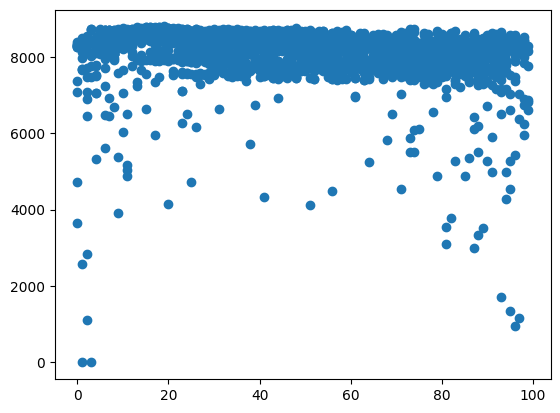

In [80]:
plt.scatter(X['Z'],y)

In [ ]:
algo = RandomForestRegressor()

#-1*cross_val_score(algo,X,y,cv=KFold(n_splits=10),scoring='neg_mean_squared_error').mean()

539865.9482011382

In [12]:
param_grid = {
    'n_estimators' : np.arange(50,150,25),
    'max_depth' : np.arange(1,15,2)
}

grid = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid,
    n_jobs=-1,
    verbose=1,
    scoring='neg_mean_squared_error',
    cv=KFold(n_splits=5)
)

grid.fit(X,y)

print(grid.best_score_*-1)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
523003.22711968684


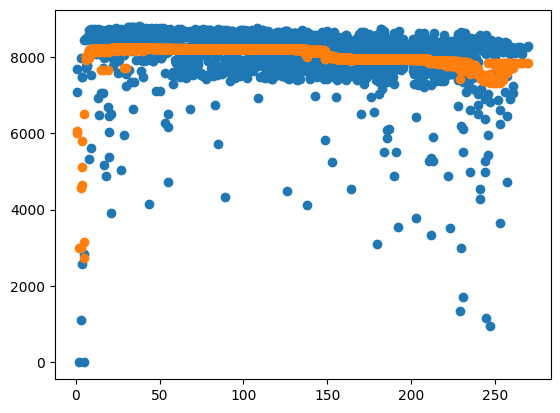

In [15]:
yhat = grid.predict(X)

plt.scatter(X['A'],y)
plt.scatter(X['A'],yhat)

In [88]:
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X)

scaler = StandardScaler().fit(X_pca)
X_norm = scaler.transform(X_pca)

param_grid = {
    'hidden_layer_sizes' : [(50,50),(50,50,50)],
    'activation' : ['logistic'],
    'solver' : ['lbfgs']
}

grid = GridSearchCV(
    estimator=MLPRegressor(max_iter=5000),
    param_grid=param_grid,
    n_jobs=-1,
    verbose=1,
    scoring='neg_mean_squared_error',
    cv=KFold(n_splits=5)
)

grid.fit(X_norm,y)

print("MSE:",grid.best_score_*-1,'\nBest Params:',grid.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/thatswhaticed/opt/anaconda3/envs/DataScience3_12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/thatswhaticed/opt/anaconda3/envs/DataScience3_12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MSE: 538984.423999921 
Best Params: {'activation': 'logistic', 'hidden_layer_sizes': (50, 50, 50), 'solver': 'lbfgs'}


494394.27461357706


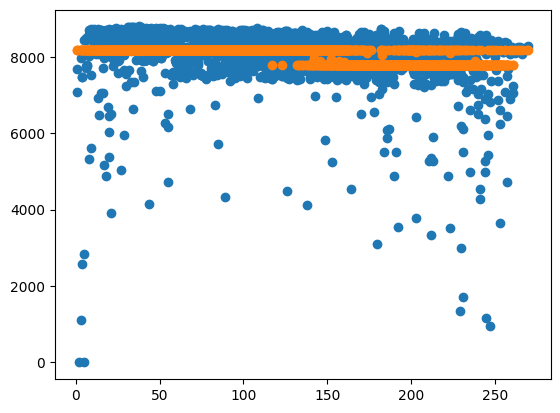

In [89]:
yhat = grid.predict(X_norm)

plt.scatter(X['A'],y)
plt.scatter(X['A'],yhat)

print(mean_squared_error(yhat,y))

Best polynomial degree from kfold cv is: 3 
MSE: 470557.4872788371


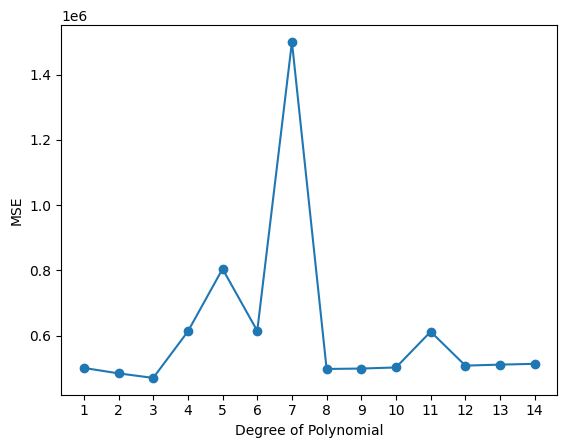

In [57]:
degs = list(range(1,15))
errors = []
for i in degs:
    polyfit = make_pipeline(PolynomialFeatures(degree=i,include_bias=False),LinearRegression())
    polyfit.fit(X,y)
    errors.append(mean_squared_error(polyfit.predict(X),y))

bestdegree = np.argmin(errors)+1
print("Best polynomial degree from kfold cv is:",bestdegree,"\nMSE:",errors[bestdegree-1])

plt.xlabel('Degree of Polynomial')
plt.ylabel('MSE')
plt.xticks(degs)
plt.plot(degs,errors)
plt.scatter(degs,errors);

470557.4872788371


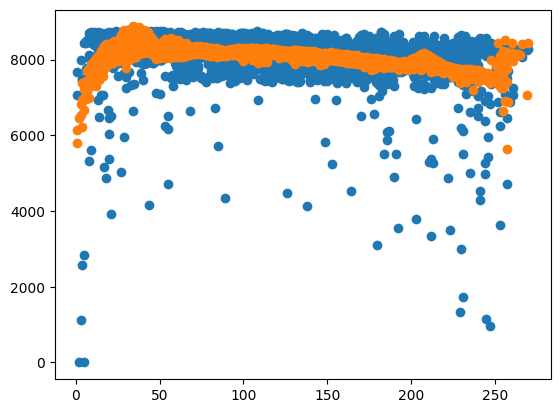

In [58]:
polyfit = make_pipeline(PolynomialFeatures(degree=bestdegree,include_bias=False),LinearRegression())
polyfit.fit(X,y)
yhat = polyfit.predict(X)

plt.scatter(X['A'],y)
plt.scatter(X['A'],yhat)

print(mean_squared_error(y,yhat))

Best Num splines: 83 
MSE: 323664.1367599523


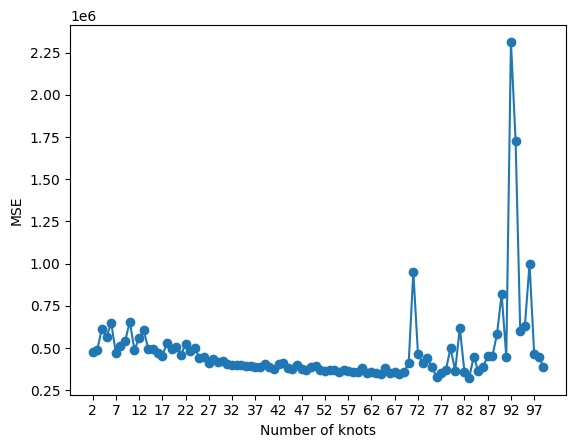

In [81]:
numsplines = list(range(2,100))
errors = []
for i in numsplines:
    polyfit = make_pipeline(SplineTransformer(n_knots=i, degree=3), LinearRegression())
    polyfit.fit(X,y)
    errors.append(mean_squared_error(polyfit.predict(X),y))

bestdegree = np.argmin(errors)+2
print("Best Num splines:",bestdegree,"\nMSE:",errors[bestdegree-2])

plt.xlabel('Number of knots')
plt.ylabel('MSE')
plt.xticks(np.arange(2,max(numsplines),5))
plt.plot(numsplines,errors)
plt.scatter(numsplines,errors);

323664.1367599523


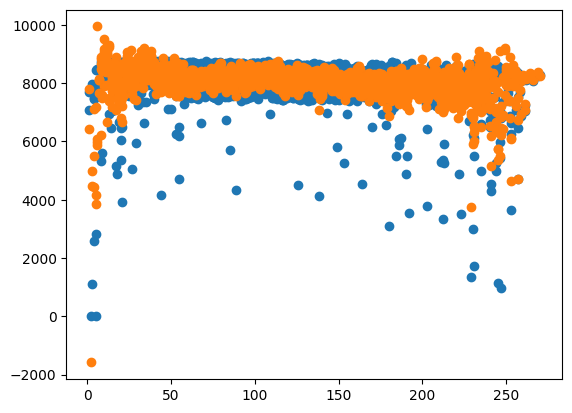

In [84]:
polyfit = make_pipeline(SplineTransformer(n_knots=bestdegree, degree=3), LinearRegression())
polyfit.fit(X,y)
yhat = polyfit.predict(X)

plt.scatter(X['A'],y)
plt.scatter(X['A'],yhat)

print(mean_squared_error(y,yhat))

Minimum MSE: 504755.410795225
Alpha at min: 1.2642599898239333


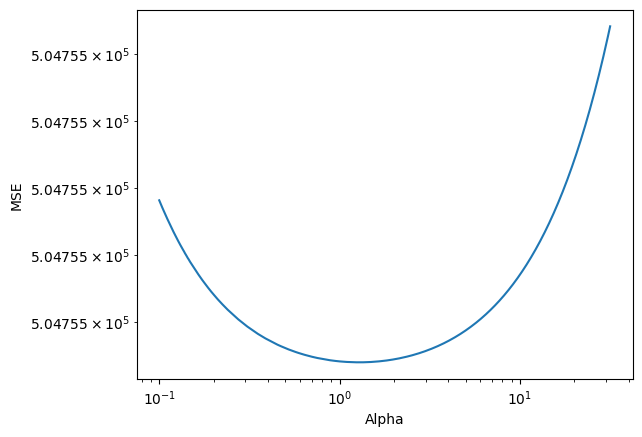

In [45]:
alphas = 10**np.linspace(-1,1.5,600)

errors = np.zeros(600)

for i,a in enumerate(alphas):
    MODEL = Ridge(alpha = a)
    errors[i] = -1*cross_val_score(MODEL,X, y, cv=KFold(n_splits=10), scoring='neg_mean_squared_error').mean()

minidx = np.argmin(errors)
print("Minimum MSE:",errors[minidx])
print("Alpha at min:",alphas[minidx])

plt.plot(alphas,errors);
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.show()

501176.12242386397


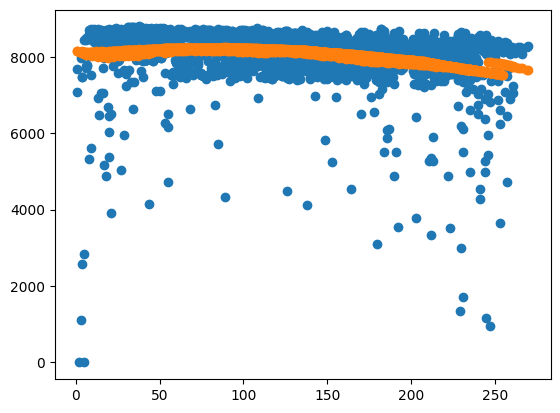

In [47]:
MODEL = Ridge(alpha = alphas[minidx])
MODEL.fit(X,y)

yhat = MODEL.predict(X)

plt.scatter(X['A'],y)
plt.scatter(X['A'],yhat)

print(mean_squared_error(y,yhat))

Minimum MSE: 504379.4150272369
Alpha at min: 3.242286731540226


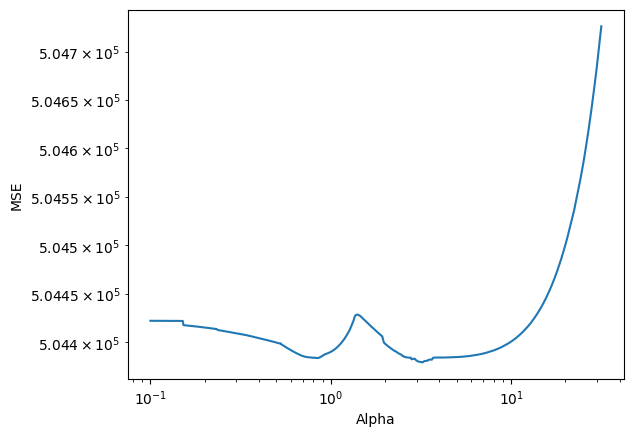

In [32]:
errors = np.zeros(600)

for i,a in enumerate(alphas):
    MODEL = Lasso(alpha = a)
    errors[i] = -1*cross_val_score(MODEL,X, y, cv=KFold(n_splits=10), scoring='neg_mean_squared_error').mean()

minidx = np.argmin(errors)
print("Minimum MSE:",errors[minidx])
print("Alpha at min:",alphas[minidx])

plt.plot(alphas,errors);
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.show()

501176.20707029366


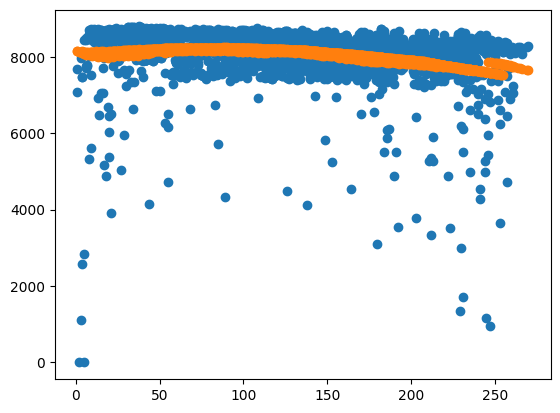

In [48]:
MODEL = Lasso(alpha = alphas[minidx])
MODEL.fit(X,y)

yhat = MODEL.predict(X)

plt.scatter(X['A'],y)
plt.scatter(X['A'],yhat)

print(mean_squared_error(y,yhat))

Optimal Number of Components: 1
Error: 504564.21775262634


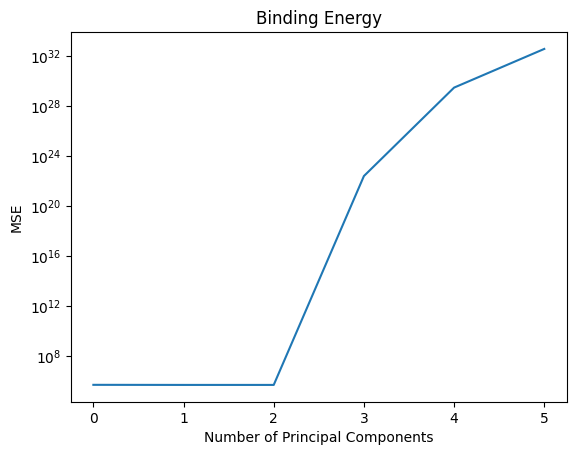

In [22]:
mses = []

for i in range(1,len(AtomicMass.columns)-2):
    LM = PLSRegression(n_components=i)
    score = -1*cross_val_score(LM,X, y, cv=KFold(n_splits=10), scoring='neg_mean_squared_error').mean()
    mses.append(score)

print("Optimal Number of Components:",np.argmin(mses))
print("Error:",mses[np.argmin(mses)])
     
plt.plot(mses)
plt.xticks(np.arange(0,len(AtomicMass.columns)-3,1))
plt.yscale('log')
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('Binding Energy');

Optimal Number of Components: 2
Error: 504636.3575456191


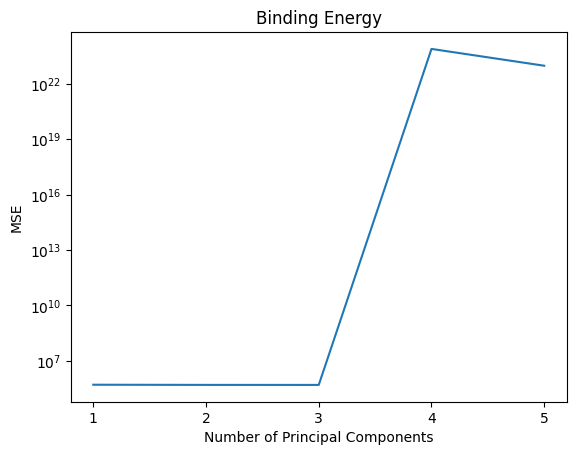

In [23]:
mses = []

scaler = StandardScaler().fit(X)
X_norm = scaler.transform(X)

for i in range(1,len(X.columns)):
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X_norm)
    LM = LinearRegression()
    LM.fit(X_pca,y)
    score = -1*cross_val_score(LM,X_pca, y, cv=10, scoring='neg_mean_squared_error').mean()
    mses.append(score)

print("Optimal Number of Components:",np.argmin(mses))
print("Error:",mses[np.argmin(mses)])
       
plt.plot(range(1,len(X.columns)),mses)
plt.xticks(range(1,len(X.columns)))
plt.yscale('log')
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('Binding Energy');